# 3D prediction full deposit

In [18]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [19]:
#two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)
two_composite_filtered = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)

In [20]:

mineral = 'Density_gcm3'
covariates = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']

#Select columns of interest
selected_columns = ["Name", 'X', 'Y', 'Z', mineral] + covariates
two_composite_1mineral = two_composite_filtered[selected_columns]

#Drop NA's 
deposit_data = two_composite_1mineral.dropna(subset=[mineral] + covariates)

In [21]:
deposit_data

,Name,X,Y,Z,Density_gcm3,Sulph1_Code,Sulph1_Pct,Sulph2_Code,Sulph2_Pct
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,PO,1.0,CP,1.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,PO,1.0,CP,1.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,PO,1.0,CP,1.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,PO,2.0,CP,1.5
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,PO,3.0,CP,2.0
...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,PO,3.0,CP,0.2
81072,KV365,3499347.32,7510617.19,83.30,3.43,PO,3.0,CP,0.2
81073,KV365,3499347.13,7510616.22,81.56,3.44,PO,3.0,CP,0.2
81074,KV365,3499346.93,7510615.24,79.83,3.40,PO,3.0,CP,0.2


C:\Users\23478671\AppData\Local\Temp\ipykernel_6644\4085638563.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_6644\4085638563.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_6644\4085638563.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

- Iteration 0, MSE: 0.2428
- Iteration 100, MSE: 0.0148
- Iteration 200, MSE: 0.0140
- Iteration 300, MSE: 0.0134
- Iteration 400, MSE: 0.0131
- Iteration 500, MSE: 0.0128
- Iteration 600, MSE: 0.0127
- Iteration 700, MSE: 0.0126
- Iteration 800, MSE: 0.0126
- Iteration 900, MSE: 0.0125
- Iteration 1000, MSE: 0.0124
- Iteration 1100, MSE: 0.0123
- Iteration 1200, MSE: 0.0123
- Iteration 1300, MSE: 0.0122
- Iteration 1400, MSE: 0.0122
- Iteration 1500, MSE: 0.0122
- Iteration 1600, MSE: 0.0121
- Iteration 1700, MSE: 0.0121
- Iteration 1800, MSE: 0.0121
- Iteration 1900, MSE: 0.0121
- Iteration 2000, MSE: 0.0120
- Iteration 2100, MSE: 0.0120
- Iteration 2200, MSE: 0.0120
- Iteration 2300, MSE: 0.0120


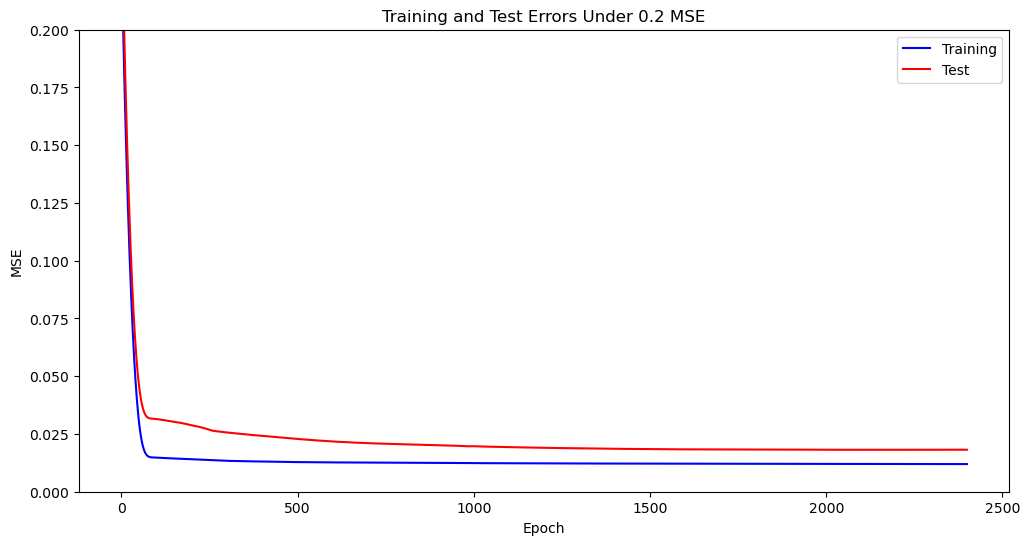

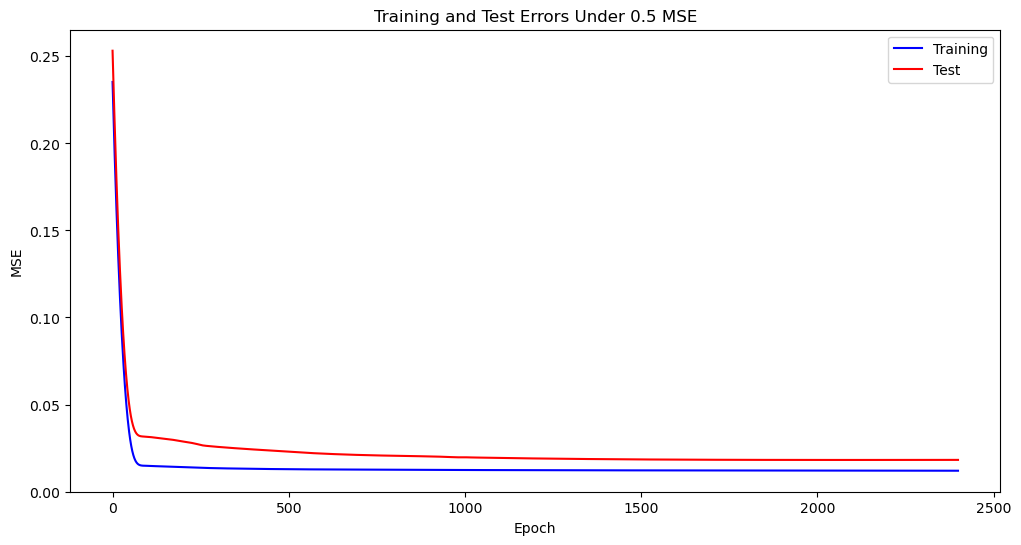

In [65]:
np.random.seed(42)
torch.manual_seed(42)


#mineral = 'Density_gcm3'
#two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
#deposit_data = two_composite_1mineral.dropna(subset=[mineral])
    
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']  # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)


# Create a MinMaxScaler instance
scaler = MinMaxScaler()


# Fit the scaler to your data and transform the specified columns
deposit_data.loc[:, [mineral]] = scaler.fit_transform(deposit_data.loc[:, [mineral]])

x = deposit_data[['X', 'Y', 'Z']].values  # Use X, Y, and Z coordinates
y = deposit_data[mineral].values[:, np.newaxis]  # Keep mineral as the output
x = x.reshape(len(deposit_data), 3)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Initialize empty lists to store training and testing data
x_train = []
y_train = []
x_test = []
y_test = []

# Iterate through unique 'Name' values and assign each hole's data to either train or test
for name in unique_names:
    # Select data for the current hole
    hole_data = deposit_data[deposit_data['Name'] == name]
    x_hole = hole_data[['X', 'Y', 'Z']].values
    y_hole = hole_data['Density_gcm3'].values

    # Assign the hole's data to either train or test
    if np.random.rand() < 0.2:  # You can adjust the ratio, e.g., 0.2 for a 80/20 split
        x_test.extend(x_hole)
        y_test.extend(y_hole)
    else:
        x_train.extend(x_hole)
        y_train.extend(y_hole)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


model = nn.Sequential(
    nn.Linear(in_features=3, out_features=30),
    nn.ReLU(),
    nn.Linear(in_features=30, out_features=1)
)

mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(2400):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')


# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.2)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()



# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()





In [66]:


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")




## Cross validation

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming your model, data, and metrics functions are defined previously
torch.manual_seed(42)
np.random.seed(42)
# Assuming deposit_data, x, and y are defined

# Extract unique 'Name' values
unique_names = deposit_data['Name'].unique()

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(unique_names)):
    train_names, test_names = unique_names[train_index], unique_names[test_index]

    # Filter data based on selected train and test names
    train_data = deposit_data[deposit_data['Name'].isin(train_names)]
    test_data = deposit_data[deposit_data['Name'].isin(test_names)]

    x_train = train_data[['X', 'Y', 'Z']].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z']].values
    y_test = test_data['Density_gcm3'].values

    # Your model definition and training code here

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=3, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(2400):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_rmse_list.append(np.sqrt(test_mse_list[-1]))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average RMSE: {np.mean(test_rmse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0208
  RMSE: 0.1444
  MAE: 0.1126
  R^2: -0.2415


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0119
  RMSE: 0.1092
  MAE: 0.0828
  R^2: 0.0537


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0068
  RMSE: 0.0828
  MAE: 0.0610
  R^2: -1.6077


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0411
  RMSE: 0.2027
  MAE: 0.1162
  R^2: -0.1741


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0049
  RMSE: 0.0700
  MAE: 0.0480
  R^2: 0.0461


Average Metrics Across Folds:
  Average MSE: 0.0171
  Average RMSE: 0.1218
  Average MAE: 0.0841
  Average R^2: -0.3847


## Randomly selected train and test sets (not by hole)

In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[['X', 'Y', 'Z']].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[['X', 'Y', 'Z']].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=3, out_features=30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(2400):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R^2: {np.mean(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0133
  RMSE: 0.1151
  MAE: 0.0807
  R^2: 0.1694


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0123
  RMSE: 0.1108
  MAE: 0.0712
  R^2: 0.0642


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0109
  RMSE: 0.1045
  MAE: 0.0657
  R^2: 0.2598


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0119
  RMSE: 0.1091
  MAE: 0.0712
  R^2: 0.1181


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0132
  RMSE: 0.1150
  MAE: 0.0735
  R^2: 0.2648


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0087
  RMSE: 0.0933
  MAE: 0.0622
  R^2: 0.3154


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0142
  RMSE: 0.1191
  MAE: 0.0798
  R^2: 0.2147


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0162
  RMSE: 0.1272
  MAE: 0.0760
  R^2: 0.1024


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0105
  RMSE: 0.1025
  MAE: 0.0736
  R^2: 0.1710


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0146
  RMSE: 0.1208
  MAE: 0.0790
  R^

In [27]:
import torch
import numpy as np

# Assuming `model` is your trained neural network
model.eval()

# Initialize an array to accumulate gradients for each feature
total_gradients = np.zeros_like(x_test[0], dtype=float)

# Iterate over all instances to accumulate gradients
for instance_index in range(len(x_test)):
    selected_instance = torch.tensor(x_test[instance_index], dtype=torch.float32).unsqueeze(0)  # Add a batch dimension
    selected_instance.requires_grad_(True)
    
    # Forward pass
    output = model(selected_instance)

    # Backward pass to compute gradients
    model.zero_grad()
    output.backward()

    # Accumulate gradients for each feature
    total_gradients += selected_instance.grad.detach().numpy()[0]

# Calculate feature importance as the absolute mean of gradients across instances
average_importance = np.abs(total_gradients / len(x_test))

# Print or use the average_importance as needed
print("Average Feature Importance:", average_importance)


Average Feature Importance: [0.19942519 0.16839632 0.18688567]


## Create output space

In [59]:

x_grid = np.linspace(x[:, 0].min(), x[:, 0].max(), 50)
y_grid = np.linspace(x[:, 1].min(), x[:, 1].max(), 50)
z_grid = np.linspace(x[:, 2].min(), x[:, 2].max(), 50)
xyz_grid = np.array(np.meshgrid(x_grid, y_grid, z_grid)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(50, 50, 50)

# Create a 3D surface plot using Plotly
# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions.ravel(), y_test.ravel()])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

## Plot of predictions + entire data

In [60]:


fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set'
))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)

fig.write_html('tmp.html', auto_open=True)



In [ ]:
# Pool the values from predictions_hole and y_hole


fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid[:,0],
    y=xyz_grid[:,1],
    z=xyz_grid[:,2],
    mode='markers',
    marker=dict(
        size=4,

        colorscale='Hot',  # Adjust the color scale

        opacity=0.7,
    ),
    name='Test set'
)])

# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,

        colorscale='Hot',  # Adjust the color scale

        opacity=0.7,

    ),
    name='Test set'
))

NameError: name 'xyz_grid' is not defined

## Showing different planes

In [ ]:
x_points = 100
y_points = 100
z_points = 100

x_grid2 = np.linspace(x[:, 0].min(), x[:, 0].max(), x_points)
y_grid2 = np.linspace(x[:, 1].min(), x[:, 1].max(), y_points)
z_grid2 = np.linspace(x[:, 2].min(), x[:, 2].max(), z_points)
xyz_grid2 = np.array(np.meshgrid(x_grid2, y_grid2, z_grid2)).T.reshape(-1, 3)

# Make predictions for the grid
predictions = model(torch.tensor(xyz_grid2, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions = predictions.data.numpy().reshape(x_points, y_points, z_points)

pooled_values = np.concatenate([predictions.ravel(), y_test.data.numpy()[:, 0], y_train.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

step_titles = ["Predictions", "Test Set", "Train Set"]

fig = go.Figure(data=[
    go.Scatter3d(
    x=xyz_grid2[:,0],
    y=xyz_grid2[:,1],
    z=xyz_grid2[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=predictions.ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Preds',
    text = ["Density: {}".format(x) for x in predictions.ravel() ]
)])


# Add a scatter plot for test data points
fig.add_trace(go.Scatter3d(
    x=x.data.numpy()[:, 0],
    y=x.data.numpy()[:, 1],
    z=x.data.numpy()[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=y.data.numpy().ravel(),
        colorscale='Hot',  # Adjust the color scale
        colorbar=dict(title=mineral),
        opacity=0.7,
        cmax=vmax,
        cmin=vmin,
    ),
    name='Test set',
    text = ["Density: {}".format(x) for x in y.data.numpy().ravel()]

))




fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',
    ),
)
fig.write_html('tmp.html', auto_open=True)
#fig.show()


## Export to CSV

In [ ]:
# import pandas as pd
# import numpy as np


# # Create a DataFrame with xyz_grid and predictions
# df = pd.DataFrame({'X': xyz_grid[:, 0].ravel(), 
#                    'Y': xyz_grid[:, 1].ravel(), 
#                    'Z': xyz_grid[:, 2].ravel(), 
#                    'Predictions': predictions.ravel()})

# # Display the DataFrame
# print(df)

# # Assuming you have the DataFrame named 'df'

# # Specify the file path for the CSV file
# csv_file_path = 'xyz_predictions.csv'

# # Export the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)

# print(f'DataFrame has been exported to {csv_file_path}')
